In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] ='2'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
#import nest 
import struct
import os
import json
import sys
import seaborn as sns 
from scipy import signal, stats

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from notebook import notebookapp
servers = list(notebookapp.list_running_servers())
print(servers)

[{'base_url': '/', 'hostname': '0.0.0.0', 'notebook_dir': '/home/jovyan', 'password': False, 'pid': 6, 'port': 8888, 'secure': False, 'token': '75df3599b40746adf0a01b12f716e8a9454945fd9c243b25', 'url': 'http://0.0.0.0:8888/'}]


## Download Data

In [279]:
%%bash 
wget -i http://neurodatasharing.bme.gatech.edu/development-data/html/wget/daily.spont.dense.full.0.0.21.list
#wget -i http://neurodatasharing.bme.gatech.edu/development-data/html/wget/daily.spont.sparse.full.0.0.24.list

--2020-02-12 10:08:06--  http://neurodatasharing.bme.gatech.edu/development-data/html/wget/daily.spont.dense.full.0.0.21.list
Resolving neurodatasharing.bme.gatech.edu (neurodatasharing.bme.gatech.edu)... 143.215.226.18
Connecting to neurodatasharing.bme.gatech.edu (neurodatasharing.bme.gatech.edu)|143.215.226.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1408 (1.4K) [text/plain]
Saving to: ‘daily.spont.dense.full.0.0.21.list’

     0K .                                                     100%  197M=0s

2020-02-12 10:08:07 (197 MB/s) - ‘daily.spont.dense.full.0.0.21.list’ saved [1408/1408]

--2020-02-12 10:08:07--  http://potterlab.bme.gatech.edu/development-data/full/daily/spont/dense/2-1-21.spike.gz
Resolving potterlab.bme.gatech.edu (potterlab.bme.gatech.edu)... 143.215.226.18
Connecting to potterlab.bme.gatech.edu (potterlab.bme.gatech.edu)|143.215.226.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5462621 (5.2M) [applicati

In [281]:
%%bash
pwd
cd ../Data
pwd

/home/jovyan/Notebooks
/home/jovyan/Data


In [142]:
%%bash
mv *.spike.gz ../Data/raw_Data
rm daily.spont.dense.full* 

mv: cannot stat '*.spike.gz': No such file or directory
rm: cannot remove 'daily.spont.dense.full*': No such file or directory


CalledProcessError: Command 'b'mv *.spike.gz ../Data/raw_Data\nrm daily.spont.dense.full* \n'' returned non-zero exit status 1.

In [283]:
%%bash 
gunzip ../Data/raw_Data/*.gz

In [3]:
data_dir = "../Data/raw_Data/"

## Load and convert spike info

### Load full bit-file info

In [4]:
def load_full_spike_info(filename, n=None):
    """ Load full-info files from  D. A. Wagenaar, J. Pine, and S. M. Potter, 2006 data set
    
    Args:
        filename (string): path to filename.spike 
        n (int): Info to the first n spikes 

    Returns:
        Spikes (dict): A dictonary of arrays with spike information
    """
    spikes = {}
    
    
    
    """
    Extract spike information stored as struct of type:
    
    typedef struct {
        unsigned long long time; /* 8-byte integer, little-endian */
        short channel; /* 2-byte integer, little-endian */
        short height;
        short width;
        short context[74];
        short threshold;
    } Spikeinfo;
    """
    
    file_length_in_bytes = os.path.getsize(filename)
    max_n = int(file_length_in_bytes/164) # spike information stored in 164 bytes
    #print(max_n)
    #print(n is None)
    if n is None:
        n = max_n
    elif n > max_n:
        print("File contains info on %d spikes max" % max_n)
        n = max_n

        
    # information of culture and day 
    info = filename.split("/")[-1].split(".")[0]
    culture = info.split("-")[0] + "." + info.split("-")[1]
    day = info.split("-")[2]
    
    spikes["culture"] = [culture] * n 
    spikes["day"] = [day] * n   
        
    with open(filename,'rb') as file:
        raw = file.read()
        file.close()  
        
    #print(n)
    for i in range(n):
        unpacked1 = np.asarray(struct.unpack('<Q', raw[i*164:i*164+8])) # 8-byte integer, little-endian
        unpacked2 = np.asarray(struct.unpack('<hhh74hh', raw[i*164+8:i*164+8+156])) # 156-byte integer, little-endian 
        time = unpacked1[0]
        channel = unpacked2[0]
        height = unpacked2[1]
        width = unpacked2[2]
        context = unpacked2[3:77] # context[74]
        threshold = unpacked2[77]
        if i == 0:
            spikes["time"] = [time]
            spikes["channel"] = [channel]
            spikes["height"] = [height]
            spikes["width"] = [width]
            #spikes["context"] = [context]
            spikes["threshold"] = [threshold]
        else:
            spikes["time"].append(time)
            spikes["channel"].append(channel)
            spikes["height"].append(height)
            spikes["width"].append(width)
            #spikes["context"].append(context)
            spikes["threshold"].append(threshold)
    
    
    spikes["time"] = np.asarray(spikes["time"])
    spikes["channel"] = np.asarray(spikes["channel"])
    spikes["height"] = np.asarray(spikes["height"])
    spikes["width"] = np.asarray(spikes["width"])
    #spikes["context"] = np.asarray(spikes["context"])
    spikes["threshold"] = np.asarray(spikes["threshold"])
    
    
    # convert to units
    # Time is the time of the spike, in units of the sample period (40 μs) --> seconds .
    # Channel is the electrode channel on which the spike occurred. Channels 0..59 are actual electrodes; channel 60 is used to mark the occurrence of stimuli.
    # Height is the amplitude of the detected spike, in digital units, i.e. 0.33 μV --> μV.
    # Width is the duration of the spike, in units of the sample period (40 μs) --> ms.
    # Context is 74 samples worth of context, from 1 ms before the peak to 2 ms after the peak of the spike, in digital units, 0.33 μV per step. Sampling frequency is 25 kHz.
    # Threshold is the spike detection threshold in force at the time of this detection.
    #spikes["time"] = np.asarray(spikes["time"])/25000 
    #spikes["height"] = np.asarray(spikes["time"])
    r = 683
    auxrange = r * 1.2
    freq = 25.0
    
    #isaux = np.where(np.asarray(spikes["channel"])>=0)
    iselc = np.where(spikes["channel"]<60)
    
    
    spikes["height"][iselc] = spikes["height"][iselc] * r/2048
    spikes["threshold"][iselc] = spikes["threshold"][iselc]  * r/2048
    #spikes["context"][iselc] = spikes["context"][iselc] * r/2048
    
    #spikes["height"][isaux] = np.asarray(spikes["height"])[isaux] * auxrange/2048
    #spikes["threshold"][isaux] = np.asarray(spikes["threshold"])[isaux] * auxrange/2048
    #spikes["context"][isaux] = np.asarray(spikes["context"])[isaux] * auxrange/2048

    spikes["time"] = spikes["time"]/(freq*1000)
    spikes["width"] = spikes["width"]/(freq)
    
    return spikes

## Helper functions

In [5]:
def calc_spike_counts(spike_train, interval, starting_zero=True):
        """
        Produces the spike counts array of this spike train, given the interval
        :param interval: counting interval, in seconds
        :return: an array of spike counts
        """
        if(len(spike_train)>0):
            latest_spike = max(spike_train)
            if starting_zero:
                earliest_spike = 0
            else:
                earliest_spike = min(spike_train)
            counts = np.diff([np.count_nonzero(spike_train < t) for t in np.arange(earliest_spike, latest_spike, interval)]) # count_nonzero counts all spikes occuring in intervals prev to current one --> difference to get spike counts per interval 
        else:
            counts = []
        return counts
    
def calc_inter_spike_interval(spike_train):
        isi = np.diff(spike_train)
        return isi

In [6]:
def sqrt_transformation(burst_batch):
    transformed_batch = []
    for burst in burst_batch:
        transformed_burst = []
        for channel in range(burst.shape[0]):
            transformed_burst.append(np.sqrt(burst[channel]))
        transformed_batch.append(np.asarray(transformed_burst))
    return transformed_batch

# -------------------------------------------------------------------------------------------
## Burst Detection

- ≥ 2 channels active at the same time with overlapping burstlets 
- sequence of one or more burstlets with non-zero temporal overlap

### Burstlets: 
- sequences ≥ 4 spikes 
- inter-spike intervals < threshold 
- threshold = 1/4 * 1/average spike detection rate, or 100 ms if the average spike detection rate < 10 Hz
- 'core' burstlet + past and future spikes ISIs < min(200,1/3 * 1/average spike detection rate)

In [7]:
def burstlets_detection(data_culture):
    # burstlets: sequences of at least four spikes 
    # - inter-spike intervals < threshold 
    # - threshold = 1/4 * 1/average spike detection rate, 
    #               or 100 ms if the average spike detection rate < 10 Hz

    # channel spike-trains, inter spike intervals and thresholds
    channels = len(data_culture["channel"].unique())
    burstlets_detection_thresholds= []
    burstlets_context_thresholds = []
    inter_spike_intervals = []
    spike_trains=[]
    for i in range(channels):
        # spike train for each channel
        spike_train = data_culture[data_culture["channel"]==i]['time'] 
        spike_trains.append(np.asarray(spike_train))
        
        # spike count for active time
        spike_count = calc_spike_counts(spike_train, interval=1, starting_zero=False) 
        
        # threshold
        threshold = 1/np.mean(spike_count)*0.25 # ensures suceeding spikes faster 4 * average firing rate considered burstlets
        threshold = min(0.1,threshold) 
        
        context_threshold = 1/(3*np.mean(spike_count))
        context_threshold = min(0.2,context_threshold)
        
        burstlets_detection_thresholds.append(threshold)
        burstlets_context_thresholds.append(context_threshold)
        
        # inter spike interval for each channel
        isi = calc_inter_spike_interval(spike_train)
        inter_spike_intervals.append(isi)
        #spike_count = None
        del spike_count
    
    # spikes sequences with inter-spike < threshold  
    channel_burstlet_candidates =[] #spike sequences with inter-spike < threshold for each channel
    channel_burstlet_candidates_with_context = []
    
    for i,isi in enumerate(inter_spike_intervals): # for inter spike intervals of each channel
        burstlet_candidates = [] # seen sequences 
        burstlet_candidates_with_context = [] 
        
        current_core_seq = [] # current sequence to check
        current_context_seq = []
        for j, inter in enumerate(isi): # go through isi of spike train in channel 
            
            if inter <= burstlets_detection_thresholds[i]:
                current_core_seq.append(spike_trains[i][j]) #spike time in current sequence
                
            if inter <= burstlets_context_thresholds[i]:
                current_context_seq.append(spike_trains[i][j])

            else:
                current_context_seq.append(spike_trains[i][j])
                burstlet_candidates_with_context.append(current_context_seq)
                current_context_seq = []
                
                current_core_seq.append(spike_trains[i][j]) #last spike time in current sequence
                burstlet_candidates.append(current_core_seq)
                current_core_seq = [] # go on with and collect next sequence 
                
        channel_burstlet_candidates.append(burstlet_candidates)
        channel_burstlet_candidates_with_context.append(burstlet_candidates_with_context)
        
        #print(len(burstlet_candidates),len(burstlet_candidates_with_context))
    
    #burstlets_detection_thresholds = None
    del burstlets_detection_thresholds
    #burstlets_context_thresholds = None
    del burstlets_context_thresholds
    #inter_spike_intervals = None
    del inter_spike_intervals
    #spike_trains = None
    del spike_trains
    # sequences with at least four spikes
    burstlets = []
    burstlets_with_context = []

    for i, sequences in enumerate(channel_burstlet_candidates):
        candidates_with_context = channel_burstlet_candidates_with_context[i]
        for j, seq in enumerate(sequences): # go thourgh each sequence and check wether more than 4 spikes included   
            if len(seq)>=4:
                burstlets.append([seq[0],seq[-1]]) # start and end point
                burstlet_seq_with_context = candidates_with_context[j]
                burstlets_with_context.append([burstlet_seq_with_context[0], burstlet_seq_with_context[-1]])
        
    
    burstlets_in_time = np.sort(np.asarray(burstlets), axis = 0)
    burstlets_with_context_in_time = np.sort(np.asarray(burstlets_with_context), axis = 0)
    
    
    
    return burstlets_in_time, burstlets_with_context_in_time

def burst_detection(burstlets):
    
    bursts=[]
    j= 1
    count_burstlets = 1

    current_burstlet = burstlets[0]
    next_burstlet = burstlets[j]
    start_time = current_burstlet[0]
    end_time = current_burstlet[1]


    while(j<len(burstlets)-1):
        if next_burstlet[0] <= end_time: # burstlet starts before current ends --> ongoing 
            count_burstlets += 1
            end_time = max(next_burstlet[1],end_time) # set new end  
            j += 1
            next_burstlet = burstlets[j]
        else:
            bursts.append([start_time,end_time,count_burstlets]) # end of burstlet sequence 
            count_burstlets = 1 # restet count 
            current_burstlet = next_burstlet # set current burstlet
            j += 1
            next_burstlet = burstlets[j] # set next burstlet
            start_time = current_burstlet[0] # set new starting time of potential burst
            end_time = current_burstlet[1] # set new end time
        
        
    bursts = np.asarray(bursts)
    detected_bursts = bursts[np.where(bursts[:,2] > 1)] # more than 2 channels active at the same time with overlapping burstlets 
    return detected_bursts

In [8]:
def verify_detected_bursts(data_culutre,detected_bursts):
    bins = np.arange(0,max(data_culutre['time'])+1,1)
    sc,_ = np.histogram(data_culutre['time'], bins = bins)
    
    plt.figure(figsize=(15,5))
    plt.plot(detected_bursts[:,0],detected_bursts[:,2],"x",markersize=10)
    plt.plot(sc)
    plt.xlim([0,1000])
    #plt.yscale("log")

### Burst Data
- extract whole network data during detected burst times
- add the time of minmal interburst interval as context for all bursts
- bin the data in 10 ms bins
- tiny bursts: burst spanning fewer than 5 electrodes

In [9]:
def extract_burst_data(data_culture, detected_bursts, include_context = True):

    #add start and end point of the recording for inter burst interval calculation 
    flattened = np.insert(detected_bursts, 0, [0,0,0], axis=0) 
    flattened = np.insert(flattened, len(flattened), [max(data_culture['time']),max(data_culture['time']),0], axis = 0)
    flattened = flattened[:,0:2].flatten()

    
    interburst_interval = np.diff(flattened)[1::2]
    if include_context:
        min_interburst_interval = min(interburst_interval)
        print("Minimum Interburst Interval: ", min_interburst_interval)
    else:
        min_interburst_interval = 0
    

    for i, detected_burst in enumerate(detected_bursts):
        interval_before = detected_burst[0] - min_interburst_interval#min(0.2, interburst_interval[i])
        interval_after = detected_burst[1] + min_interburst_interval#min(0.2, interburst_interval[i+1])
        if i == 0:  
            burst_data = data_culture[(interval_before <= data_culture['time']) & (data_culture['time'] <= interval_after)]
            burst_data = burst_data.assign(burst = i)
        else:
            data_i = data_culture[(interval_before <= data_culture['time']) & (data_culture['time'] <= interval_after)]
            data_i = data_i.assign(burst = i)
            burst_data = burst_data.append(data_i, ignore_index = True)
    return burst_data

### Binning Bursts 
- 10 ms intervals

### Padding Bursts
- burst peaks align = "peak"
    - algin by latest peak 
    - zero padding to maximal possible length (shift longest burst with burst nearly at onset)
- burst onset align = "onset"
    - zero padding to length of longest burst

In [10]:
def bin_burst_data(burst_data,channels=60, binsize = 0.01):
    burst_batch = []
    too_short_burst_indices = []
    counter = 0
    
    for i,burst in enumerate(burst_data["burst"].unique()):
        spike_train = burst_data[burst_data["burst"] == burst][["time","channel"]]
        burst_beginning = min(spike_train["time"])
        burst_ending = max(spike_train["time"])
        if np.abs(burst_ending - burst_beginning)<binsize:
            counter += 1
            print(counter, "Found too short burst: Duration = ", np.abs(burst_ending - burst_beginning))
            too_short_burst_indices.append(i)
            continue
        length = np.ceil((burst_ending-burst_beginning)/binsize)
        #test = np.arange(min(spike_train["time"]),max(spike_train["time"]), 0.02)
        #print(length, len(test))
                    
        burst_array = np.zeros(shape=(channels, int(length)))
        #print(burst_array.shape)
        for channel in spike_train["channel"].unique():
            current_channel = spike_train[spike_train["channel"]==channel]["time"]
            start = int(np.ceil((min(current_channel) - burst_beginning)/binsize))
            spike_count = calc_spike_counts(current_channel, binsize, starting_zero = False)
            #print(channel,start,len(spike_count))
            burst_array[int(channel), start:start+len(spike_count)] = spike_count
        if np.count_nonzero(burst_array) > 0:
            burst_batch.append(burst_array)
        else:
            counter += 1
            print(counter, "Found flat burst: Duration = ", np.abs(burst_ending - burst_beginning))
            too_short_burst_indices.append(i)
    return burst_batch, too_short_burst_indices

def burst_batch_padding(burst_batch, channels=60, padding = "onset"):
    durations = []
    #channel_averaged_bursts = []
    burst_peaks = []
    for burst in burst_batch:
        durations.append(burst.shape[1])
        channel_averaged_burst = np.mean(burst, axis = 0)
        #channel_averaged_bursts.append(channel_averaged_burst)
        burst_peak = np.argmax(channel_averaged_burst)
        burst_peaks.append(burst_peak)

    max_duration = max(durations)
    longest_burst = np.argmax(durations)
        
    if padding == "onset":
        burst_batch_pad = np.zeros((len(burst_batch),channels,max_duration))
        for i,burst in enumerate(burst_batch):
            padding = max_duration - burst.shape[1]
            burst_batch_pad[i,:,:] = np.pad(burst, ((0, 0), (0, padding)), 'constant')
        return burst_batch_pad
    
    elif padding == "peak":
        latest_peak = max(burst_peaks)
        shifts = latest_peak - np.asarray(burst_peaks) + durations
        #print(latest_peak, np.argmax(burst_peaks))
        #print(max_duration, longest_burst)
        max_shifted = max(shifts)
        shifts = None
        durations = None
            
        burst_batch_pad = np.zeros((len(burst_batch),channels,max_shifted))
        center = latest_peak
        print("Peak centering at: ", center)
        print("Padding to length: ", max_shifted)
        for i, burst in enumerate(burst_batch):   
            peak_position = burst_peaks[i]
            peak_shift = center - peak_position
                
            end_padding = max_shifted - (burst.shape[1] + peak_shift)
            #print(peak_shift,burst.shape[1], end_padding)
            burst_batch_pad[i,:,:] = np.pad(burst, ((0, 0), (peak_shift, end_padding)), 'constant')
        return burst_batch_pad, center
    else:
        print("No padding applied")
        return burst_batch

## Save burst data

In [11]:
def save_burst_data_as_json(df, data_dir, filename):
    df.to_json(data_dir + "%s.JSON" % filename)

def load_burst_data_from_json(filename):
    return pd.read_json(data_dir + "%s.JSON" % filename)

def save_burst_batch(batch, data_dir, filename):
    if isinstance(batch, np.ndarray):
        list_of_lists = batch.tolist()
    else:
        list_of_lists = []
        for i,burst in enumerate(batch):
            list_of_lists.append(burst.tolist())
    
    with open(data_dir + "%s.JSON" % filename, 'w') as filehandle:  
        filehandle.write(json.dumps(list_of_lists))
    filehandle.close()

# Dataset
- whole dataset
- dataset without bursts referred to as tiny
- dataset containing only bursts referred to as tiny

# Data Prepocessing
## Culturewise 
1. load raw data spike files
2. extract burst data from raw files 
3. bin burst data 
4. save the extracted and binned data 

## Culturewide 
1. load the extracted burst data for cultures you want to analyse
2. combine burst batches to one dataset
3. padd and center all cultures together 
4. save padded and centered data 
5. average burst data over channels 


## Culturewise 

### Culturewise 1. load the raw data files (.spike)

In [12]:
data_dir = "../Data/raw_Data/"

In [13]:
spike_files = [x for x in os.listdir(data_dir) if x.endswith(".spike")]
print(spike_files)
culture_names = [x.split(".")[0].replace("-","_") for x in spike_files]
print(culture_names)

[]
[]


In [14]:
already_converted_spike_files = [x.split('.')[0] for x in os.listdir(data_dir) if x.find("burst_data_batch") >= 0 and x.find("padded") <0 ]
already_converted_cultures = ["-".join(x.split("_")[3:]) + ".spike" for x in already_converted_spike_files]
print("Already converted cultures: ", np.sort(already_converted_cultures))

cultures_to_convert = [file for file in spike_files if file not in already_converted_cultures]
print("Culture to convert: ", cultures_to_convert)

Already converted cultures:  []
Culture to convert:  []


### Culturewise 2-4. Extract, bin and save burst data for each culture

In [15]:
def data_preprocessing(spike_files, data_dir):
    culture_names = [x.split(".")[0].replace("-","_") for x in spike_files]
    for i,file in enumerate(spike_files):
        data_culture_full = load_full_spike_info(data_dir + file)
        data_culture_full = pd.DataFrame.from_dict(data_culture_full)
        
        #data_culture_full.head()
        
        burstlets,burstlets_with_context = burstlets_detection(data_culture_full)
        detected_bursts_with_context =  burst_detection(burstlets_with_context)
        #detected_bursts_no_tiny = detected_bursts_with_context[np.where(detected_bursts_with_context[:,2] > 5)]
        
        
        #verify_detected_bursts(data_culture_full,detected_bursts_with_context)
        
        if len(detected_bursts_with_context) > 0: 
            burst_data = extract_burst_data(data_culture_full, detected_bursts_with_context)
            #burst_data_no_tiny = extract_burst_data(data_culture_full, detected_bursts_no_tiny)
            #burst_data_tiny = extract_burst_data(data_culture_full, detected_bursts_tiny)
            #burst_data.head()

            burst_batch, too_short_burst_indices = bin_burst_data(burst_data)
            #burst_batch_no_tiny = bin_burst_data(burst_data_no_tiny)
            #burst_batch_tiny = bin_burst_data(burst_data_tiny)

            # Padding and center each Culture seperatly 

            #padded_burst_batch, center = burst_batch_padding(burst_batch, padding = "peak") 
            #padded_burst_batch_no_tiny, center_no_tiny = burst_batch_padding(burst_batch_no_tiny, padding = "peak") 
            #padded_burst_batch_tiny, center_tiny = burst_batch_padding(burst_batch_tiny, padding = "peak") 

            #burst_by_time = np.mean(padded_burst_batch,axis = 1).T
            #burst_by_time_no_tiny = np.mean(padded_burst_batch_no_tiny, axis = 1).T
            #burst_by_time_tiny = np.mean(padded_burst_batch_tiny, axis = 1).T
            #channel_by_time = np.mean(padded_burst_batch,axis = 0).T

            #print("Burst data Batch: ", padded_burst_batch.shape)
            #print("Burst data Batch (no tiny): ", padded_burst_batch_no_tiny.shape)
            #print("Burst data Batch (tiny): ", padded_burst_batch_tiny.shape)
            #print("Averaged over channels: ", burst_by_time.shape)
            #print("Averaged over channels (no tiny): ", burst_by_time_no_tiny.shape)
            #print("Averaged over channels (tiny): ", burst_by_time_tiny.shape)

            #print("Averaged over bursts: ", channel_by_time.shape)
            
            valid_binned_detected_bursts_with_context = np.delete(detected_bursts_with_context,too_short_burst_indices,axis=0)
            detected_bursts_tiny_index = np.where(valid_binned_detected_bursts_with_context[:,2] <= 5)
            
            
            print("Active Channels in Bursts: ", valid_binned_detected_bursts_with_context[:,2])
            print("#Bursts: ", len(valid_binned_detected_bursts_with_context))
            print("Mean burst duration: ", np.mean(valid_binned_detected_bursts_with_context[:,1]- valid_binned_detected_bursts_with_context[:,0]))
            print("Variance of burst duration: ", np.var(valid_binned_detected_bursts_with_context[:,1]- valid_binned_detected_bursts_with_context[:,0]))
        
            
            
            
            
            print(len(valid_binned_detected_bursts_with_context), np.amax(detected_bursts_tiny_index))
            
            save_burst_data_as_json(burst_data, data_dir, "burst_data_" + culture_names[i])
            #save_burst_data_as_json(burst_data_no_tiny, "burst_data_no_tiny_" + culture_names[i])
            #save_burst_data_as_json(burst_data_tiny, "burst_data_tiny_" + culture_names[i])
            save_burst_batch(burst_batch, data_dir, "burst_data_batch_" + culture_names[i])
            #save_burst_batch(burst_batch_no_tiny,"burst_data_batch_no_tiny_" + culture_names[i])
            #save_burst_batch(burst_batch_tiny,"burst_data_batch_tiny_" + culture_names[i])
            #save_burst_batch(padded_burst_batch,"burst_data_batch_padded_" + culture_names[i])
            #save_burst_batch(padded_burst_batch_no_tiny,"burst_data_batch_padded_no_tiny_" + culture_names[i])
            #save_burst_batch(padded_burst_batch_tiny,"burst_data_batch_padded_tiny_" + culture_names[i])
            np.save(data_dir + 'burst_data_batch_tiny_index_' + culture_names[i], detected_bursts_tiny_index)
            
            #data_culture_full = None
            del data_culture_full
            #burstlets = None
            del burstlets
            #burstlets_with_context = None
            del burstlets_with_context
            #detected_bursts_with_context = None
            del detected_bursts_with_context
            #burst_data = None
            del burst_data
            #burst_batch = None
            del burst_batch
            
        else:
            print("No bursts found in %s" % culture_names[i])
            
            

In [289]:
data_preprocessing(cultures_to_convert, data_dir)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Minimum Interburst Interval:  0.000240000000019
1 Found too short burst: Duration =  0.00767999999999
2 Found too short burst: Duration =  0.00504000000001
3 Found too short burst: Duration =  0.0057599999999
4 Found too short burst: Duration =  0.00608
5 Found too short burst: Duration =  0.00656000000004
6 Found too short burst: Duration =  0.00464000000011
7 Found too short burst: Duration =  0.00951999999984
8 Found too short burst: Duration =  0.00983999999994
Active Channels in Bursts:  [  2.  46.   2.   2.   4.   3.  14.   3.  14.  39.   2.   2.   2.  43.   2.
  20.   2.  10.  13.  90.   2.  41.  29.  31.   9.  40.  34.   2.  12.   5.
  11.  26.   5.   4.   6.  24.  56.  12.   2.   6.   6.   9.   2.  23.   2.
   2.   6.   6.  61.   2.   7.   2.   8.   2.  27.  19.  23.   2.  12.   2.
   9.   2.  47.   7.   3.   4.  60.   2.  18.   2.  40.  12.   4.   5.   5.
   9.   4.   2.  25.   8.  14.   2.  50.  33.  28.   7.   5.  12.   2.  22.
   2.   3.  11.   2.   8.   4.   2.   2.  53. 

Minimum Interburst Interval:  4.00000001264e-05
1 Found too short burst: Duration =  0.00776
2 Found flat burst: Duration =  0.01028
3 Found too short burst: Duration =  0.00988
4 Found too short burst: Duration =  0.00676
5 Found too short burst: Duration =  0.00516
6 Found flat burst: Duration =  0.01288
7 Found too short burst: Duration =  0.00952000000001
8 Found too short burst: Duration =  0.00892
9 Found flat burst: Duration =  0.01164
10 Found too short burst: Duration =  0.00327999999999
11 Found flat burst: Duration =  0.01588
12 Found flat burst: Duration =  0.01036
13 Found flat burst: Duration =  0.01092
14 Found flat burst: Duration =  0.01112
15 Found flat burst: Duration =  0.01028
16 Found too short burst: Duration =  0.00703999999999
17 Found too short burst: Duration =  0.00847999999999
18 Found too short burst: Duration =  0.00820000000002
19 Found flat burst: Duration =  0.01304
20 Found flat burst: Duration =  0.01164
21 Found too short burst: Duration =  0.007559

Minimum Interburst Interval:  0.000160000000051
Active Channels in Bursts:  [  2.  13.   4.   8.  12.   9.  16.   2.  24.   7.  11.   8.  10.  17.  25.
  12.  13.  11.   2.   7.   5.  20.   9.   4.  25.   3.  18.  31.   2.  34.
  22.  10.   6.  11.  37.  24.  10.   2.   6.   8.   4.  27.  11.  12.  17.
  10.   4.  12.  13.  11.  24.  10.   2.  16.   3.  32.  16.   6.   7.  27.
   8.   2.   4.   9.  36.   8.  12.  13.   5.   2.   8.   5.   7.  26.   3.
  28.   2.  13.  18.   5.  15.  24.   3.  28.  11.   2.  26.  15.  13.  11.
  12.   7.   6.  35.  25.  12.  14.  14.  13.  10.   2.   4.  10.   7.  14.
  14.  13.  16.  13.  28.   2.   2.  14.   2.  19.  15.  14.  12.   2.  21.
  11.   4.  16.  12.   9.  13.   7.   8.  37.  22.   2.   2.  10.  10.   3.
  12.  19.  12.  16.   9.  15.  20.  28.  14.   9.  11.  13.  17.   9.   2.
  28.  22.   9.   2.  13.  11.  12.  17.  10.  10.  26.  21.   2.  15.  14.
  15.   8.   2.   4.  10.  27.  19.   5.  17.   2.  10.   4.   9.  36.   2.
  27.  13.  

Minimum Interburst Interval:  0.000239999999962
Active Channels in Bursts:  [   2.    2.    2.    2.    2.    2.    2.    2.    2.    2.    2.    2.
    2.    2.    2.    2.    2.    2.  138.   14.    2.    3.    2.    4.
    2.    3.    2.    2.    2.    2.  104.    2.    2.    3.    2.    2.
    2.    2.    4.    2.    2.    2.    2.    2.  121.    8.    2.    2.
    2.    2.   95.    2.    3.    2.    2.   93.    2.    3.    2.    3.
    2.    3.   90.    2.   66.    2.    2.    2.    3.    2.   68.    9.
    2.    2.    4.    2.    2.    2.    4.    2.    2.    2.  110.   63.
   10.    2.    2.   74.    6.    3.    2.    4.    4.    3.   92.    2.
    2.    2.   74.    2.    2.    2.    2.    2.    2.   69.    2.    2.
    2.    2.    2.    4.    2.]
#Bursts:  113
Mean burst duration:  0.940536283186
Variance of burst duration:  3.33818010194
113 112
Minimum Interburst Interval:  0.000239999999849
1 Found too short burst: Duration =  0.0086
2 Found too short burst: Duration =  0.00

150 Found too short burst: Duration =  0.00927999999999
151 Found too short burst: Duration =  0.00843999999995
152 Found too short burst: Duration =  0.00532000000004
153 Found flat burst: Duration =  0.01156
154 Found flat burst: Duration =  0.01668
155 Found too short burst: Duration =  0.00876
156 Found too short burst: Duration =  0.00752
157 Found too short burst: Duration =  0.00387999999998
158 Found flat burst: Duration =  0.01324
159 Found too short burst: Duration =  0.00443999999999
160 Found flat burst: Duration =  0.01152
161 Found too short burst: Duration =  0.00451999999996
162 Found too short burst: Duration =  0.00444000000005
163 Found too short burst: Duration =  0.00592
164 Found too short burst: Duration =  0.00432000000001
165 Found too short burst: Duration =  0.00468000000001
166 Found too short burst: Duration =  0.00892000000005
167 Found too short burst: Duration =  0.00580000000002
168 Found too short burst: Duration =  0.00600000000003
169 Found too short

309 Found too short burst: Duration =  0.00944000000004
310 Found too short burst: Duration =  0.00875999999994
311 Found too short burst: Duration =  0.00803999999994
312 Found flat burst: Duration =  0.01052
313 Found too short burst: Duration =  0.00544000000002
314 Found too short burst: Duration =  0.00540000000001
315 Found flat burst: Duration =  0.01184
316 Found too short burst: Duration =  0.00608
317 Found too short burst: Duration =  0.00560000000007
318 Found too short burst: Duration =  0.00768000000005
319 Found flat burst: Duration =  0.0124
320 Found too short burst: Duration =  0.00620000000004
321 Found flat burst: Duration =  0.0133999999999
322 Found too short burst: Duration =  0.0068
323 Found flat burst: Duration =  0.01388
324 Found too short burst: Duration =  0.0068
325 Found too short burst: Duration =  0.00852000000009
326 Found flat burst: Duration =  0.0115999999999
327 Found too short burst: Duration =  0.00908000000004
328 Found too short burst: Duratio

464 Found too short burst: Duration =  0.00468000000001
465 Found too short burst: Duration =  0.00836000000004
466 Found too short burst: Duration =  0.00932000000012
467 Found too short burst: Duration =  0.00552000000016
468 Found flat burst: Duration =  0.01532
469 Found too short burst: Duration =  0.00868000000014
470 Found too short burst: Duration =  0.00731999999994
471 Found flat burst: Duration =  0.0103200000001
472 Found flat burst: Duration =  0.01036
473 Found flat burst: Duration =  0.0158000000001
474 Found too short burst: Duration =  0.00567999999998
475 Found too short burst: Duration =  0.00900000000001
476 Found too short burst: Duration =  0.00975999999991
477 Found too short burst: Duration =  0.00747999999999
478 Found too short burst: Duration =  0.00768000000016
479 Found too short burst: Duration =  0.00927999999999
480 Found too short burst: Duration =  0.00960000000009
481 Found too short burst: Duration =  0.00551999999993
482 Found too short burst: Durat

618 Found too short burst: Duration =  0.00831999999991
619 Found flat burst: Duration =  0.01368
620 Found too short burst: Duration =  0.00543999999991
621 Found too short burst: Duration =  0.00855999999999
622 Found too short burst: Duration =  0.00459999999998
623 Found too short burst: Duration =  0.00623999999993
624 Found too short burst: Duration =  0.00675999999999
625 Found too short burst: Duration =  0.00780000000009
626 Found too short burst: Duration =  0.00675999999999
627 Found too short burst: Duration =  0.00795999999991
628 Found too short burst: Duration =  0.00915999999984
629 Found too short burst: Duration =  0.00536000000011
630 Found too short burst: Duration =  0.00595999999996
631 Found too short burst: Duration =  0.00459999999998
632 Found too short burst: Duration =  0.00744000000009
633 Found too short burst: Duration =  0.00248000000011
634 Found too short burst: Duration =  0.00312000000008
635 Found flat burst: Duration =  0.01296
636 Found too short 

99 Found too short burst: Duration =  0.0068
100 Found too short burst: Duration =  0.00628
101 Found too short burst: Duration =  0.00792000000001
102 Found too short burst: Duration =  0.00996000000004
103 Found too short burst: Duration =  0.00587999999999
104 Found flat burst: Duration =  0.01152
105 Found flat burst: Duration =  0.01368
106 Found flat burst: Duration =  0.01396
107 Found flat burst: Duration =  0.01364
108 Found flat burst: Duration =  0.01072
109 Found too short burst: Duration =  0.00747999999999
110 Found flat burst: Duration =  0.01224
111 Found too short burst: Duration =  0.00916000000001
112 Found too short burst: Duration =  0.00855999999999
113 Found too short burst: Duration =  0.00983999999994
114 Found too short burst: Duration =  0.00603999999998
115 Found flat burst: Duration =  0.01044
116 Found flat burst: Duration =  0.01088
117 Found too short burst: Duration =  0.00752
118 Found too short burst: Duration =  0.00843999999995
119 Found flat burst:

257 Found too short burst: Duration =  0.00384000000008
258 Found too short burst: Duration =  0.00728000000004
259 Found too short burst: Duration =  0.00828000000001
260 Found too short burst: Duration =  0.00891999999999
261 Found too short burst: Duration =  0.00708000000009
262 Found too short burst: Duration =  0.00563999999986
263 Found too short burst: Duration =  0.00887999999986
264 Found too short burst: Duration =  0.00947999999994
265 Found too short burst: Duration =  0.00264000000016
266 Found flat burst: Duration =  0.0145599999998
267 Found too short burst: Duration =  0.00384000000008
268 Found too short burst: Duration =  0.00980000000004
269 Found too short burst: Duration =  0.00648000000001
270 Found too short burst: Duration =  0.00404000000003
271 Found too short burst: Duration =  0.00616000000014
272 Found too short burst: Duration =  0.00276000000008
273 Found too short burst: Duration =  0.00843999999984
274 Found flat burst: Duration =  0.0137599999998
275 

5 Found too short burst: Duration =  0.00868000000003
6 Found too short burst: Duration =  0.00767999999999
7 Found too short burst: Duration =  0.00435999999996
8 Found too short burst: Duration =  0.00304000000006
9 Found too short burst: Duration =  0.00847999999996
10 Found too short burst: Duration =  0.00432000000001
11 Found too short burst: Duration =  0.00983999999994
12 Found too short burst: Duration =  0.00944000000004
13 Found too short burst: Duration =  0.00955999999996
14 Found too short burst: Duration =  0.00707999999997
15 Found flat burst: Duration =  0.01356
16 Found too short burst: Duration =  0.00716
17 Found flat burst: Duration =  0.01072
18 Found too short burst: Duration =  0.00756000000001
19 Found flat burst: Duration =  0.01316
20 Found flat burst: Duration =  0.0121199999999
21 Found flat burst: Duration =  0.0103200000001
22 Found too short burst: Duration =  0.00836000000004
23 Found too short burst: Duration =  0.00711999999999
24 Found too short burs

## Culturewide

### Culturewide 1. Load extracted culture burst data

In [16]:
data_dir = "../Data/raw_Data/Dense/"

In [17]:
def load_burst_data_from_json(data_dir, filename):
    return pd.read_json(data_dir + "%s.JSON" % filename)

def load_burst_batch(data_dir, filename):
    with open(data_dir + '%s.JSON' % filename, 'r') as filehandle:
        return json.loads(filehandle.read())
    filehandle.close()

In [18]:
def nested_ndarrays(data):
    return [np.asarray(x) for x in data]

In [24]:
spike_batch_data = [x for x in os.listdir(data_dir) if x.find("burst_data_batch_") >= 0 and (x.find("20")) >= 0 and x.find("padded") <0 and x.find("tiny") <0 and x.find("short")<0] # + x.find("21")
#sparse_spike_batch_data = ["Sparse/" + x for x in os.listdir(data_dir + "Sparse") if x.find("burst_data_batch_") >= 0 and x.find("20") >= 0 and x.find("padded") <0 and x.find("tiny") <0]
tiny_burst_indices = [x for x in os.listdir(data_dir) if x.find("burst_data_batch_tiny_index") >= 0 and (x.find("20")) >= 0] # + x.find("21")


data_batch_names = [x.split('.')[0] for x in spike_batch_data]
#sparse_data_batch_names = [x.split('.')[0] for x in sparse_spike_batch_data]
#data_batch_names += sparse_data_batch_names

data_batch_names_for_tiny_indices = [x.split('.')[0] for x in tiny_burst_indices]


print(data_batch_names)
print(data_batch_names_for_tiny_indices)


['burst_data_batch_3_1_20', 'burst_data_batch_5_3_20', 'burst_data_batch_2_6_20', 'burst_data_batch_7_2_20', 'burst_data_batch_3_6_20', 'burst_data_batch_8_2_20', 'burst_data_batch_1_5_20', 'burst_data_batch_5_2_20', 'burst_data_batch_2_2_20', 'burst_data_batch_2_1_20', 'burst_data_batch_3_2_20', 'burst_data_batch_3_3_20', 'burst_data_batch_3_4_20', 'burst_data_batch_8_3_20', 'burst_data_batch_2_4_20', 'burst_data_batch_1_2_20', 'burst_data_batch_8_1_20', 'burst_data_batch_7_1_20', 'burst_data_batch_2_3_20', 'burst_data_batch_3_5_20', 'burst_data_batch_5_1_20', 'burst_data_batch_2_5_20', 'burst_data_batch_1_1_20']
['burst_data_batch_tiny_index_5_1_20', 'burst_data_batch_tiny_index_3_5_20', 'burst_data_batch_tiny_index_8_2_20', 'burst_data_batch_tiny_index_5_2_20', 'burst_data_batch_tiny_index_1_5_20', 'burst_data_batch_tiny_index_7_2_20', 'burst_data_batch_tiny_index_5_3_20', 'burst_data_batch_tiny_index_3_1_20', 'burst_data_batch_tiny_index_1_1_20', 'burst_data_batch_tiny_index_3_2_20

In [25]:
def load_batch_files_with_number_bursts(data_dir, data_batch_names):
    data_batches = {}
    for data_name in data_batch_names:
        burst_data = load_burst_batch(data_dir,data_name)
        burst_data = nested_ndarrays(burst_data)
        #print(data_name,len(burst_data))
        data_batches[data_name] = burst_data
    return data_batches

In [26]:
data_batches = load_batch_files_with_number_bursts(data_dir, data_batch_names)

In [0]:
#data_batches_no_tiny = load_batch_files_with_number_bursts(data_batch_names_no_tiny)

In [0]:
#data_batches_tiny = load_batch_files_with_number_bursts(data_batch_names_tiny)

### Culturewide 2. Combine burst batches to one dataset

In [27]:
def merge_data_batches_ordered(data_batches,day_wise = False):
    keys = np.sort(list(data_batches.keys()))
    if day_wise:
        culture_names = []
        days = np.sort(np.unique([x.split("_")[-1] for x in keys]))
        for day in days:
            day_i = keys[[day in culture for culture in keys]]
            culture_names += list(np.sort(day_i))
    else:
        culture_names = keys
    data = []
    burst_counts = []
    culture_bursts = {}
    for i,key in enumerate(culture_names):
        burst_count = len(data_batches[key])
        burst_counts.append(burst_count)
        culture_bursts[key] = burst_count
        print(key, burst_count)
        data += data_batches[key]
    print("#Cultures: ", len(culture_names), " #Bursts (total): ", np.sum(burst_counts))
    print(np.cumsum(burst_counts))
    return data, culture_bursts

In [28]:
def load_tiny_indices_per_culture(data_dir, tiny_indices_names, day_wise = False, nd_position = True):    
    keys = np.sort(list(tiny_indices_names))
    if day_wise:
        culture_names = []
        days = np.sort(np.unique([x.split("_")[-1] for x in keys]))
        for day in days:
            day_i = keys[[day in culture for culture in keys]]
            culture_names += list(np.sort(day_i))
    else:
        culture_names = keys
        
    tiny_burst_counts = {}
    tiny_bursts_indices = {}
    
    for i,key in enumerate(culture_names):
        if nd_position:
            indices = np.load(data_dir + key + ".npy")[0]   
        else: 
            indices = np.load(data_dir + key + ".npy")
        burst_count = len(indices)
        tiny_burst_counts[key] = burst_count
        tiny_bursts_indices[key] = indices
        
        print(key, burst_count)
    
    print("#Cultures: ", len(culture_names), " #Tiny Bursts (total): ", np.sum(list(tiny_burst_counts.values())))
    print(np.cumsum(list(tiny_burst_counts.values())))
    return tiny_burst_counts, tiny_bursts_indices

In [81]:
#cultures previously used: 1.1, 1.2, 2.4, 2.6, 5.1, 5.2, 5.3, 7.1, 7.2
#prev_cultures = ["burst_data_batch_1_1_20","burst_data_batch_1_2_20", "burst_data_batch_2_4_20", "burst_data_batch_2_6_20", "burst_data_batch_5_1_20", "burst_data_batch_5_2_20", "burst_data_batch_5_3_20", "burst_data_batch_7_1_20", "burst_data_batch_7_2_20"]
#prev_batches = {}
#for key in data_batches.keys():
#    if key in prev_cultures:
#        prev_batches[key] = data_batches[key]

In [29]:
data, culture_counts = merge_data_batches_ordered(data_batches, day_wise = False)
#data, culture_counts = merge_data_batches_ordered(prev_batches)
#data_batches = None
#data_no_tiny, no_tiny_cultures_counts = merge_data_batches_ordered(data_batches_no_tiny)
#data_batches_no_tiny = None
#data_tiny, tiny_cultures_counts = merge_data_batches_ordered(data_batches_tiny)
#data_batches_tiny = None

burst_data_batch_1_1_20 141
burst_data_batch_1_2_20 531
burst_data_batch_1_5_20 128
burst_data_batch_2_1_20 194
burst_data_batch_2_2_20 1782
burst_data_batch_2_3_20 2112
burst_data_batch_2_4_20 1656
burst_data_batch_2_5_20 554
burst_data_batch_2_6_20 235
burst_data_batch_3_1_20 661
burst_data_batch_3_2_20 143
burst_data_batch_3_3_20 142
burst_data_batch_3_4_20 2853
burst_data_batch_3_5_20 61
burst_data_batch_3_6_20 338
burst_data_batch_5_1_20 231
burst_data_batch_5_2_20 30
burst_data_batch_5_3_20 156
burst_data_batch_7_1_20 270
burst_data_batch_7_2_20 416
burst_data_batch_8_1_20 77
burst_data_batch_8_2_20 96
burst_data_batch_8_3_20 285
#Cultures:  23  #Bursts (total):  13092
[  141   672   800   994  2776  4888  6544  7098  7333  7994  8137  8279
 11132 11193 11531 11762 11792 11948 12218 12634 12711 12807 13092]


In [30]:
culture_counts

{'burst_data_batch_1_1_20': 141,
 'burst_data_batch_1_2_20': 531,
 'burst_data_batch_1_5_20': 128,
 'burst_data_batch_2_1_20': 194,
 'burst_data_batch_2_2_20': 1782,
 'burst_data_batch_2_3_20': 2112,
 'burst_data_batch_2_4_20': 1656,
 'burst_data_batch_2_5_20': 554,
 'burst_data_batch_2_6_20': 235,
 'burst_data_batch_3_1_20': 661,
 'burst_data_batch_3_2_20': 143,
 'burst_data_batch_3_3_20': 142,
 'burst_data_batch_3_4_20': 2853,
 'burst_data_batch_3_5_20': 61,
 'burst_data_batch_3_6_20': 338,
 'burst_data_batch_5_1_20': 231,
 'burst_data_batch_5_2_20': 30,
 'burst_data_batch_5_3_20': 156,
 'burst_data_batch_7_1_20': 270,
 'burst_data_batch_7_2_20': 416,
 'burst_data_batch_8_1_20': 77,
 'burst_data_batch_8_2_20': 96,
 'burst_data_batch_8_3_20': 285}

In [31]:
tiny_burst_counts, tiny_bursts_indices = load_tiny_indices_per_culture(data_dir, data_batch_names_for_tiny_indices, day_wise = False)

burst_data_batch_tiny_index_1_1_20 36
burst_data_batch_tiny_index_1_2_20 313
burst_data_batch_tiny_index_1_5_20 43
burst_data_batch_tiny_index_2_1_20 171
burst_data_batch_tiny_index_2_2_20 1517
burst_data_batch_tiny_index_2_3_20 1463
burst_data_batch_tiny_index_2_4_20 1314
burst_data_batch_tiny_index_2_5_20 314
burst_data_batch_tiny_index_2_6_20 215
burst_data_batch_tiny_index_3_1_20 475
burst_data_batch_tiny_index_3_2_20 124
burst_data_batch_tiny_index_3_3_20 128
burst_data_batch_tiny_index_3_4_20 1962
burst_data_batch_tiny_index_3_5_20 39
burst_data_batch_tiny_index_3_6_20 315
burst_data_batch_tiny_index_5_1_20 175
burst_data_batch_tiny_index_5_2_20 3
burst_data_batch_tiny_index_5_3_20 104
burst_data_batch_tiny_index_7_1_20 104
burst_data_batch_tiny_index_7_2_20 236
burst_data_batch_tiny_index_8_1_20 61
burst_data_batch_tiny_index_8_2_20 49
burst_data_batch_tiny_index_8_3_20 242
#Cultures:  23  #Tiny Bursts (total):  9403
[  36  349  392  563 2080 3543 4857 5171 5386 5861 5985 6113 8

In [32]:
def get_tiny_burst_indices_for_merged_data(culture_counts, tiny_bursts_indices):
    tiny_indices_per_culture = list(tiny_bursts_indices.values())
    found_bursts_per_culture = list(culture_counts.values())
    offset = 0
    tiny_bursts_in_data_indices = []
    
    for i,indices in enumerate(tiny_indices_per_culture):
        if i == 0:
            tiny_bursts_in_data_indices += list(indices) 
        else:
            offset += found_bursts_per_culture[i-1]
            shifted_indices = indices + offset
            tiny_bursts_in_data_indices += list(shifted_indices)
    return tiny_bursts_in_data_indices

In [33]:
tiny_bursts_in_data_indices = get_tiny_burst_indices_for_merged_data(culture_counts, tiny_bursts_indices)

In [34]:
tiny_burst_counts

{'burst_data_batch_tiny_index_1_1_20': 36,
 'burst_data_batch_tiny_index_1_2_20': 313,
 'burst_data_batch_tiny_index_1_5_20': 43,
 'burst_data_batch_tiny_index_2_1_20': 171,
 'burst_data_batch_tiny_index_2_2_20': 1517,
 'burst_data_batch_tiny_index_2_3_20': 1463,
 'burst_data_batch_tiny_index_2_4_20': 1314,
 'burst_data_batch_tiny_index_2_5_20': 314,
 'burst_data_batch_tiny_index_2_6_20': 215,
 'burst_data_batch_tiny_index_3_1_20': 475,
 'burst_data_batch_tiny_index_3_2_20': 124,
 'burst_data_batch_tiny_index_3_3_20': 128,
 'burst_data_batch_tiny_index_3_4_20': 1962,
 'burst_data_batch_tiny_index_3_5_20': 39,
 'burst_data_batch_tiny_index_3_6_20': 315,
 'burst_data_batch_tiny_index_5_1_20': 175,
 'burst_data_batch_tiny_index_5_2_20': 3,
 'burst_data_batch_tiny_index_5_3_20': 104,
 'burst_data_batch_tiny_index_7_1_20': 104,
 'burst_data_batch_tiny_index_7_2_20': 236,
 'burst_data_batch_tiny_index_8_1_20': 61,
 'burst_data_batch_tiny_index_8_2_20': 49,
 'burst_data_batch_tiny_index_8_3_2

In [35]:
#np.save(data_dir + "tiny_bursts_culture_counts_20_21.npy", tiny_burst_counts)
#np.save(data_dir + 'tiny_bursts_in_data_indices_20_21.npy', tiny_bursts_in_data_indices)

In [328]:
#np.save(data_dir + 'culture_counts_20_21.npy', culture_counts)

### Dataset Burst Distribution

In [36]:
data_dir = "../Data/raw_Data/Dense/"

In [37]:
culture_counts = np.load(data_dir + "culture_counts_20.npy").item()
tiny_culture_counts = np.load(data_dir + "tiny_bursts_culture_counts_20.npy").item()

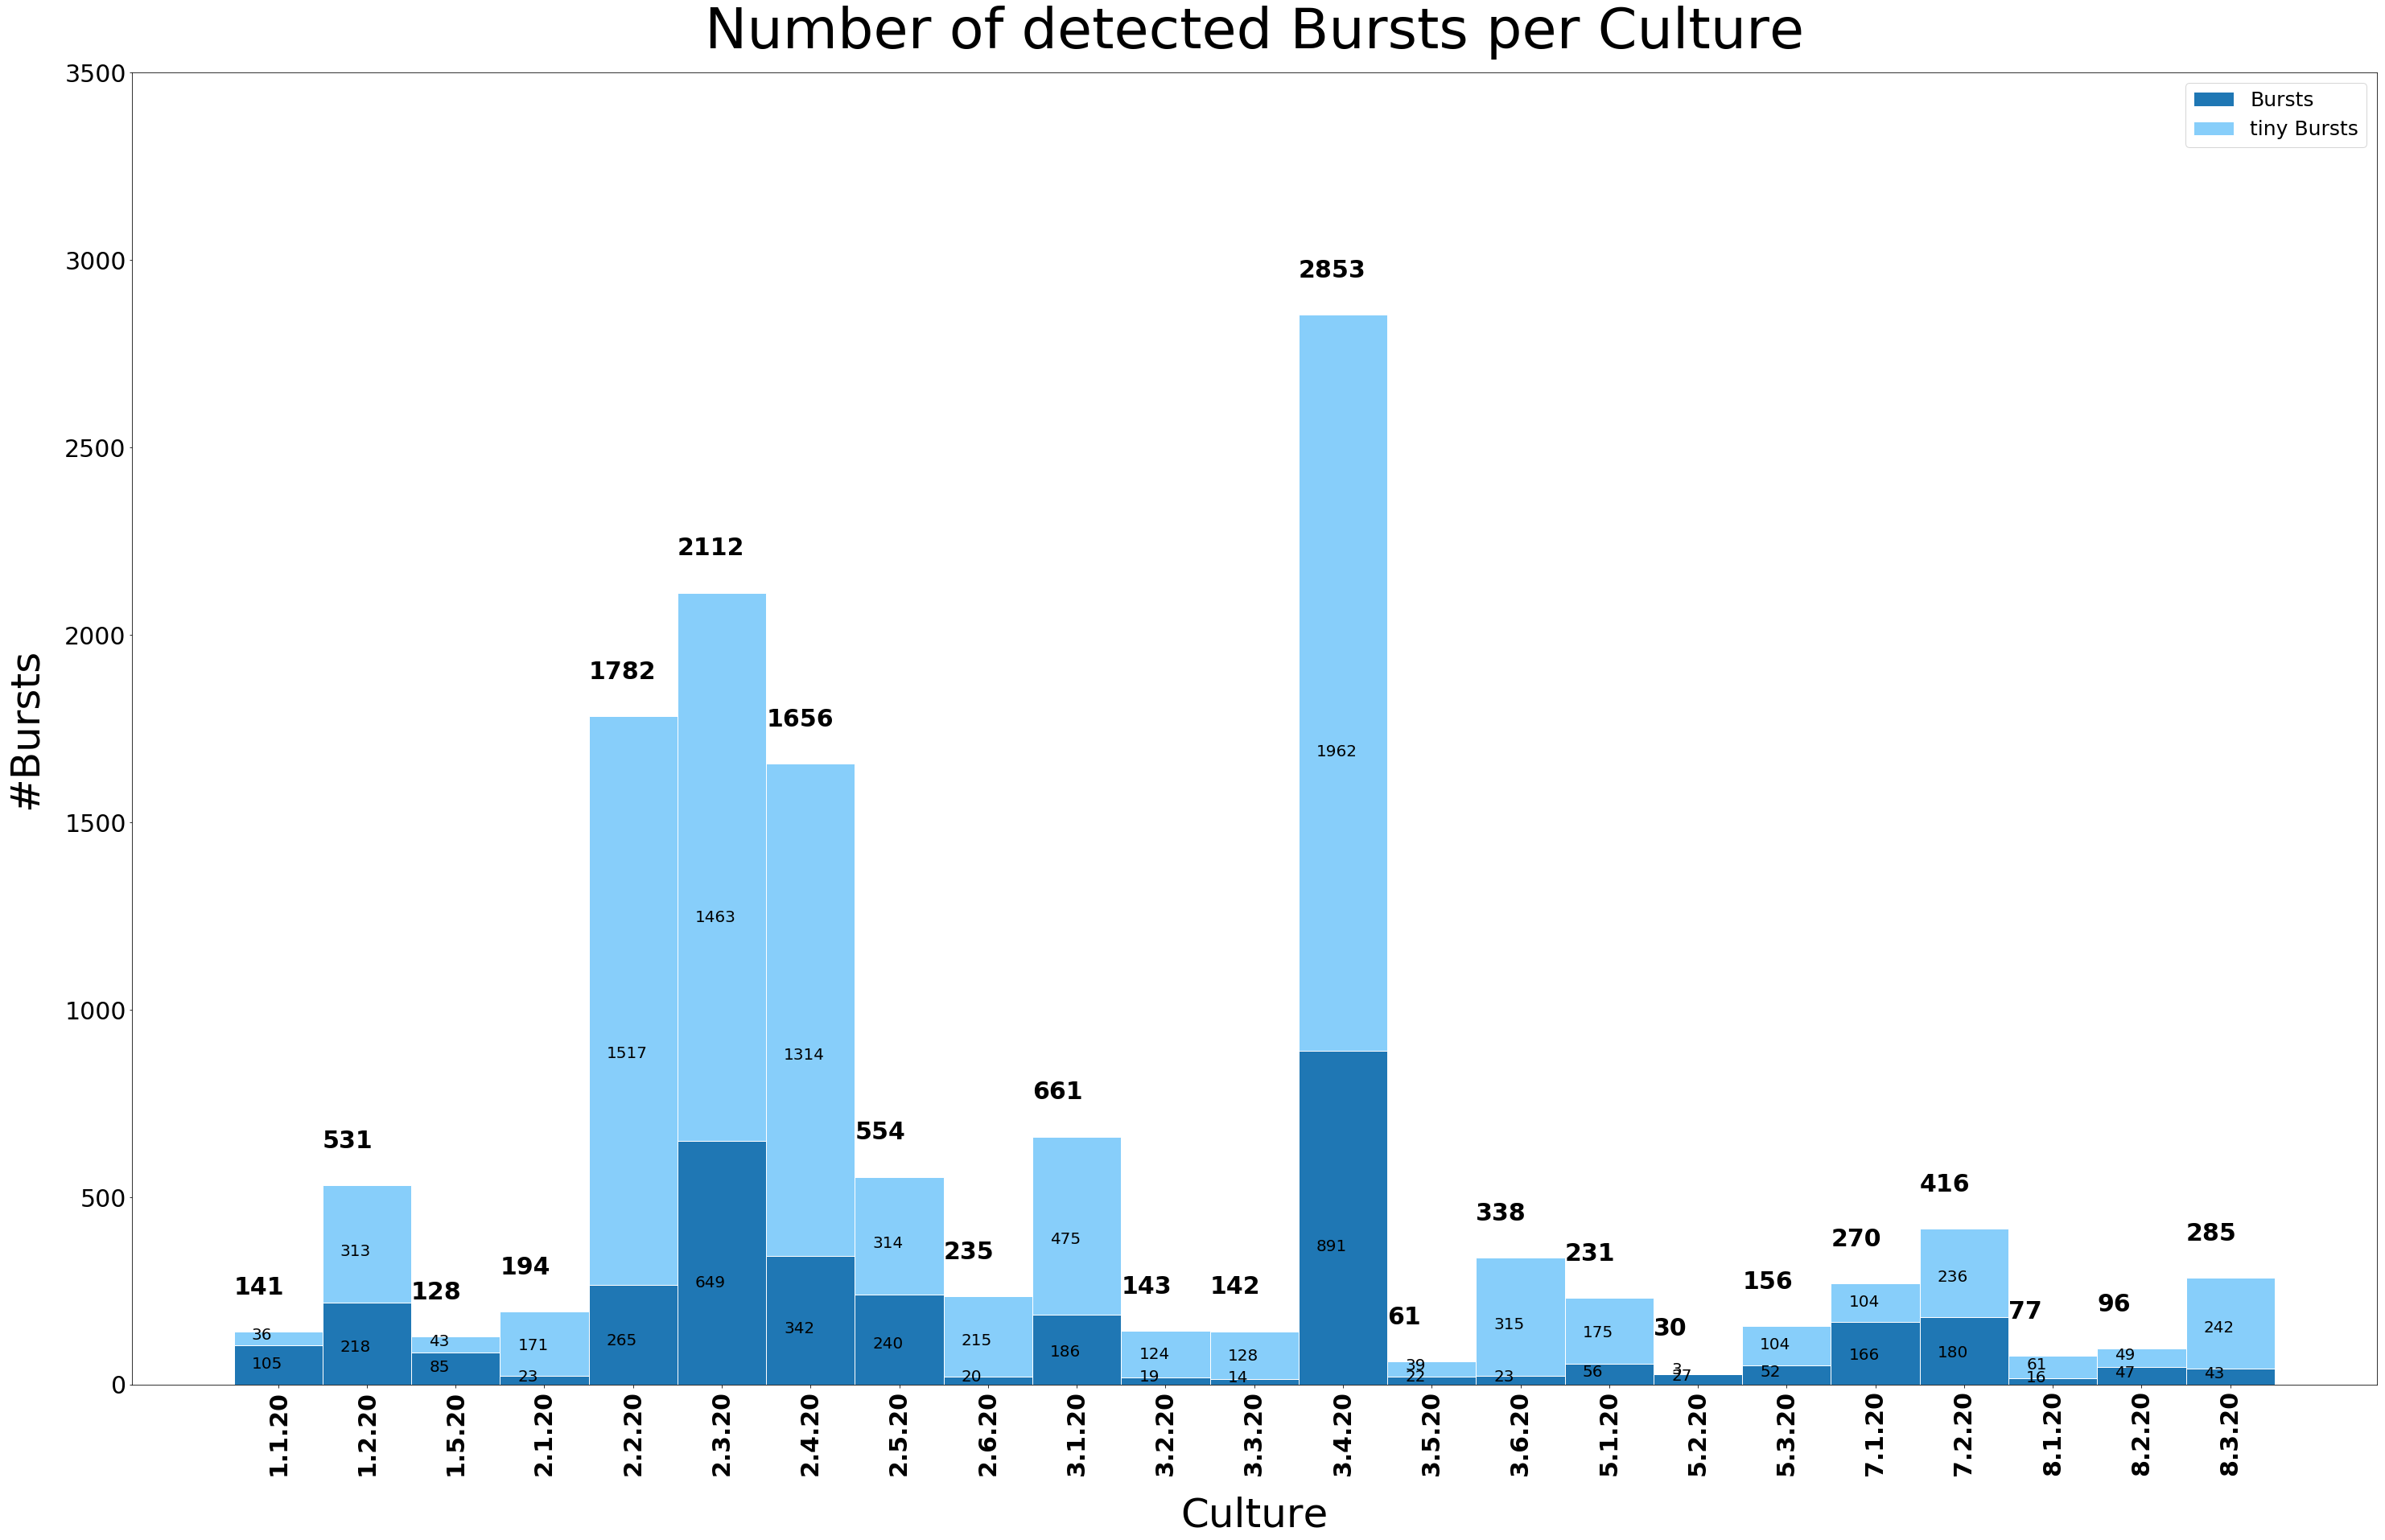

In [38]:
# The position of the bars on the x-axis
r = range(len(culture_counts.keys())) 
 
# Names of group and bar width
keys = np.sort(list(culture_counts.keys()))

names = ["sparse_" + ".".join(x.split('_')[-3:]) if x.find("Sparse")>=0 else ".".join(x.split('_')[-3:]) for x in keys]
bar_tiny = [tiny_culture_counts[key] for key in np.sort(list(tiny_culture_counts.keys()))]
bar_no_tiny = [culture_counts[key.replace("_tiny_index", "")] - tiny_culture_counts[key] for key in np.sort(list(tiny_culture_counts.keys()))]
#bar = [culture_counts[key] for key in np.sort(list(culture_counts.keys()))]
barWidth = 1

fig, ax = plt.subplots(figsize=(50,30))

ax.bar(r, bar_no_tiny,edgecolor='white', width=barWidth, label = "Bursts")
ax.bar(r, bar_tiny, bottom=bar_no_tiny, edgecolor='white',width=barWidth, label = "tiny Bursts", color ="lightskyblue")

#ax.bar(r, bar, edgecolor = 'white', width = barWidth, color = "dodgerblue")


for i,p in enumerate(ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.2, p.get_y() + p.get_height()*0.4), fontsize = 20)
    if i >= int(len(ax.patches)/2) : 
        ax.annotate(str(culture_counts[keys[i - len(keys)]]), (p.get_x(), p.get_y() + p.get_height() + 100), fontsize = 30 ,fontweight='bold')
    

    #if len(annotation) < 3:
    #    ax.annotate(annotation, (p.get_x()+0.3, p.get_y() + p.get_height() + 100), fontsize = 25,fontweight='bold')
    #elif len(annotation) == 3:
    #    ax.annotate(annotation, (p.get_x()+0.3, p.get_y() + p.get_height() + 100), fontsize = 25,fontweight='bold')
    #else: 
    #    ax.annotate(annotation, (p.get_x()+0.2, p.get_y() + p.get_height() + 100), fontsize = 25,fontweight='bold')
        

# Custom X axis
ax.set_xticks(r)
ax.set_xticklabels(names,fontsize = 30, rotation='vertical', fontweight='bold')
ax.set_xlabel("Culture", fontsize = 50, labelpad=25)
ax.set_ylabel("#Bursts", fontsize = 50, labelpad=25)
ax.set_yticks(range(0,4000,500))
ax.set_yticklabels(range(0,4000,500),fontsize = 30)
ax.set_title("Number of detected Bursts per Culture",fontsize = 70,pad = 30)
# Show graphic
ax.legend(fontsize = 25)
#ax.set_title("Burst per culture", fontsize = 40)

In [388]:
names = np.sort(np.asarray(keys))
cultures_on_both_days = []
bursts_for_matching_both_days = []
for i, name in enumerate(keys[0:-1]):
    c = name[:-2]
    if keys[i+1].startswith(c):
        cultures_on_both_days += [name,keys[i+1]]
        bursts_for_matching_both_days += [culture_counts[name], culture_counts[keys[i+1]]]

print(bursts_for_matching_both_days)

[194, 127, 1782, 2415, 2112, 1333, 1656, 771, 554, 292, 235, 118, 661, 820, 143, 113, 142, 173, 2853, 1655, 61, 54, 338, 519, 270, 282, 416, 457]


### Culturewide 3. Padding and Centering of the Dataset

In [69]:
padded_data, data_center = burst_batch_padding(data, padding = "peak")

Peak centering at:  8699
Padding to length:  16967


In [70]:
data_burst_by_time = np.mean(padded_data,axis = 1).T
data_burst_by_time_shuffled = (np.random.permutation(data_burst_by_time.T)).T
print("Burst data Batch: ", padded_data.shape)
print("Averaged over channels: ", data_burst_by_time.shape)
print("Centered at: ", data_center)

Burst data Batch:  (13189, 60, 16967)
Averaged over channels:  (16967, 13189)
Centered at:  8699


### Culturewide 4. Save Dataset

In [40]:
data_dir = "../Data/"
#np.save(data_dir + 'padded_data_sparse_vs._dense_20.npy', padded_data)
#np.save(data_dir + 'data_burst_by_time_sparse_vs._dense_20.npy', data_burst_by_time)
#padded_data = None

In [0]:
#padded_data = np.load(data_dir + 'padded_data_sparse_vs._dense_20.npy')

### Culturewide 5. Average Dataset over channels

In [48]:
data_burst_by_time = np.load(data_dir + 'raw_Data/data_burst_by_time_20_21.npy') #np.load(data_dir + 'data_burst_by_time.npy') data_burst_by_time_20_21
tiny_bursts_in_data_indices = np.load(data_dir + 'raw_Data/Dense/tiny_bursts_in_data_indices_20_21.npy')
#data_burst_by_time_shuffled = (np.random.permutation(data_burst_by_time.T)).T
print("Averaged over channels: ", data_burst_by_time.shape)

Averaged over channels:  (3410, 24663)


In [49]:
tiny_bursts = data_burst_by_time.T[tiny_bursts_in_data_indices]
tiny_bursts.shape

(17507, 3410)

In [50]:
no_tiny_bursts = np.delete(data_burst_by_time.T,tiny_bursts_in_data_indices,axis = 0)
no_tiny_bursts.shape

(7156, 3410)

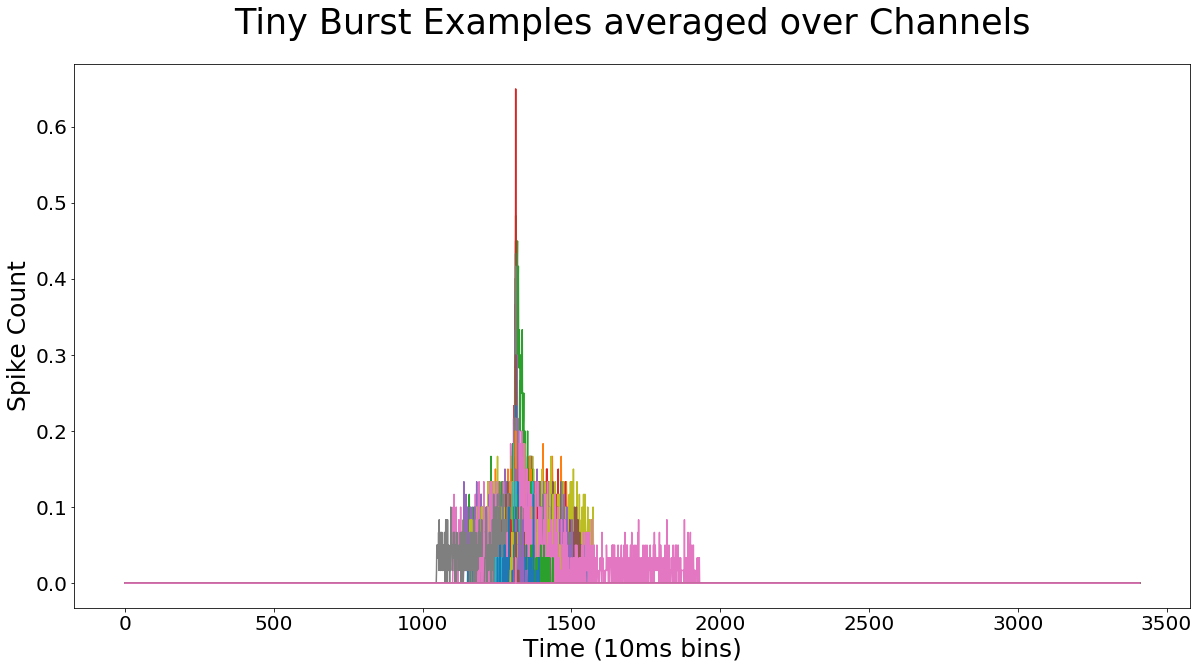

In [53]:
plt.figure(figsize=(20,10))
for burst in tiny_bursts:#[0:2000]:
    plt.plot(burst)
    
plt.xlabel("Time (10ms bins)",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Spike Count",fontsize = 25)
plt.title("Burst Examples averaged over Channels",fontsize = 35,pad = 30)    
#plt.xlim((7500,11000))
plt.show()